## Example notebook to load Argo data from GDAC

For this exercise, I use data from the Jan 2021 snapshot: https://www.seanoe.org/data/00311/42182/#80076

Data files need to uncompressed. The core and bgc Argo data are stored in separate folders. For some weird reason, both the argo and bgc tarfiles uncompress to the same name. For example 'aoml_core.tar.gz' and 'aoml_bgc.tar.gz' both become 'aoml/', so I renamed the bgc folder to 'aoml_bgc/'.

The first section of the notebook goes through the process of finding southern ocean Argo profiles. Towards the end, I combine all the steps into a single function called `find_SO_profiles()`. You should be able to copy-paste that cell into its own script. Lastly, I do a brief demo of how to examine the data.

The main step that's missing is combining all the Southern Ocean data into a single file. 

In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime

# make nice plots
import matplotlib.ticker as mticker
import cartopy.crs as ccrs 
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator, LongitudeLocator

In [2]:
archive_mon = '202101'
argo_data_dir = '/Volumes/Free/%s-ArgoData/dac' %archive_mon

In [3]:
# list data directory contents (make sure you have already uncompressed the data files)
os.listdir(argo_data_dir)

['.DS_Store',
 'aoml',
 'aoml_bgc',
 'aoml_bgc.tar.gz',
 'aoml_core.tar.gz',
 'ar_greylist.txt',
 'ar_index_global_meta.txt.gz',
 'ar_index_global_prof.txt',
 'ar_index_global_tech.txt.gz',
 'ar_index_global_traj.txt.gz',
 'argo_bio-profile_index.txt',
 'argo_bio-traj_index.txt',
 'argo_profile_detailled_index.txt.gz',
 'argo_synthetic-profile_index.txt.gz',
 'bodc',
 'bodc_bgc',
 'bodc_bgc.tar.gz',
 'bodc_core.tar.gz',
 'coriolis',
 'coriolis_bgc',
 'coriolis_bgc.tar.gz',
 'coriolis_core.tar.gz',
 'csio',
 'csio_bgc',
 'csio_bgc.tar.gz',
 'csio_core.tar.gz',
 'csiro',
 'csiro_bgc',
 'csiro_bgc.tar.gz',
 'csiro_core.tar.gz',
 'incois',
 'incois_bgc',
 'incois_bgc.tar.gz',
 'incois_core.tar.gz',
 'jma',
 'jma_bgc',
 'jma_bgc.tar.gz',
 'jma_core.tar.gz',
 'kma',
 'kma_bgc',
 'kma_bgc.tar.gz',
 'kma_core.tar.gz',
 'kordi',
 'kordi_bgc',
 'kordi_bgc.tar.gz',
 'kordi_core.tar.gz',
 'meds',
 'meds_bgc',
 'meds_bgc.tar.gz',
 'meds_core.tar.gz',
 'nmdis',
 'nmdis_core.tar.gz']

**NOTE 1**: For some weird reason, both the core and bgc tarfiles uncompress with the same name. For example 'aoml_core.tar.gz' and 'aoml_bgc.tar.gz' both become 'aoml/'. I had to rename all the bgc folders.

**NOTE 2**: To unzip the text files on my mac, I did in `gunzip  blah_blah.txt.gz` in the Terminal

## Examine index files

In [4]:
# print the first few lines in 'ar_index_global_prof.txt' (you can also just open the text file and look at it)
core_argo_index_fpath = os.path.join(argo_data_dir, 'ar_index_global_prof.txt')

N = 15
with open(core_argo_index_fpath, 'r') as file:
    for i in range(N):
        line = next(file)
        print(line)


# Title : Profile directory file of the Argo Global Data Assembly Center

# Description : The directory file describes all individual profile files of the argo GDAC ftp site.

# Project : ARGO

# Format version : 2.0

# Date of update : 20210108202423

# FTP root number 1 : ftp://ftp.ifremer.fr/ifremer/argo/dac

# FTP root number 2 : ftp://usgodae.org/pub/outgoing/argo/dac

# GDAC node : CORIOLIS

file,date,latitude,longitude,ocean,profiler_type,institution,date_update

aoml/13857/profiles/R13857_001.nc,19970729200300,0.267,-16.032,A,845,AO,20181011180520

aoml/13857/profiles/R13857_002.nc,19970809192112,0.072,-17.659,A,845,AO,20181011180521

aoml/13857/profiles/R13857_003.nc,19970820184545,0.543,-19.622,A,845,AO,20181011180521

aoml/13857/profiles/R13857_004.nc,19970831193905,1.256,-20.521,A,845,AO,20181011180521

aoml/13857/profiles/R13857_005.nc,19970911185808,0.720,-20.768,A,845,AO,20181011180521

aoml/13857/profiles/R13857_006.nc,19970922195702,1.756,-21.566,A,845,AO,2018101118052

In [5]:
# read in 'ar_index_global_prof.txt' as a numpy array (big file. takes a few seconds to load)
core_argo_index = np.genfromtxt(core_argo_index_fpath, comments='#', delimiter=',', dtype='unicode')

In [6]:
print(core_argo_index[:5, :])

[['file' 'date' 'latitude' 'longitude' 'ocean' 'profiler_type'
  'institution' 'date_update']
 ['aoml/13857/profiles/R13857_001.nc' '19970729200300' '0.267' '-16.032'
  'A' '845' 'AO' '20181011180520']
 ['aoml/13857/profiles/R13857_002.nc' '19970809192112' '0.072' '-17.659'
  'A' '845' 'AO' '20181011180521']
 ['aoml/13857/profiles/R13857_003.nc' '19970820184545' '0.543' '-19.622'
  'A' '845' 'AO' '20181011180521']
 ['aoml/13857/profiles/R13857_004.nc' '19970831193905' '1.256' '-20.521'
  'A' '845' 'AO' '20181011180521']]


In [7]:
# print file paths
print(core_argo_index[:10, 0])

['file' 'aoml/13857/profiles/R13857_001.nc'
 'aoml/13857/profiles/R13857_002.nc' 'aoml/13857/profiles/R13857_003.nc'
 'aoml/13857/profiles/R13857_004.nc' 'aoml/13857/profiles/R13857_005.nc'
 'aoml/13857/profiles/R13857_006.nc' 'aoml/13857/profiles/R13857_007.nc'
 'aoml/13857/profiles/R13857_008.nc' 'aoml/13857/profiles/R13857_009.nc']


In [8]:
# print latitudes
print(core_argo_index[:10, 2])

['latitude' '0.267' '0.072' '0.543' '1.256' '0.720' '1.756' '2.595'
 '1.761' '1.804']


In [9]:
# do the same for the BGC index file

# here, I just create a function to print the first few lines. 
# This way I don't have to copy-paste the same few lines.
def printFirstFewLines(fpath, N=15):
    """
    Input:
        fpath: path to text file
        N: number of lines to read
    """
    with open(fpath, 'r') as file:  # the a opens it in append mode
        for i in range(N):
            line = next(file)
            print(line)

In [13]:
bgc_argo_index_fpath = os.path.join(argo_data_dir, 'argo_bio-profile_index.txt')

# use function created above to print first 20 lines
printFirstFewLines(bgc_argo_index_fpath, N=20)

# Title : Bio-Profile directory file of the Argo Global Data Assembly Center

# Description : The directory file describes all individual bio-profile files of the argo GDAC ftp site.

# Project : ARGO

# Format version : 2.2

# Date of update : 20210108202402

# FTP root number 1 : ftp://ftp.ifremer.fr/ifremer/argo/dac

# FTP root number 2 : ftp://usgodae.org/pub/outgoing/argo/dac

# GDAC node : CORIOLIS

file,date,latitude,longitude,ocean,profiler_type,institution,parameters,parameter_data_mode,date_update

aoml/1900722/profiles/BD1900722_001.nc,20061022021624,-40.316,73.389,I,846,AO,PRES TEMP_DOXY BPHASE_DOXY DOXY,RRRD,20200312153230

aoml/1900722/profiles/BD1900722_002.nc,20061101064423,-40.390,73.528,I,846,AO,PRES TEMP_DOXY BPHASE_DOXY DOXY,RRRD,20200312153230

aoml/1900722/profiles/BD1900722_003.nc,20061111101222,-40.455,73.335,I,846,AO,PRES TEMP_DOXY BPHASE_DOXY DOXY,RRRD,20200312153230

aoml/1900722/profiles/BD1900722_004.nc,20061121075021,-40.134,73.080,I,846,AO,PRES TEMP_DOXY 

In [14]:
# read in bgc index file as numpy array
bgc_argo_index = np.genfromtxt(bgc_argo_index_fpath, comments='#', delimiter=',', dtype='unicode')

In [15]:
print(bgc_argo_index[:5, :])

[['file' 'date' 'latitude' 'longitude' 'ocean' 'profiler_type'
  'institution' 'parameters' 'parameter_data_mode' 'date_update']
 ['aoml/1900722/profiles/BD1900722_001.nc' '20061022021624' '-40.316'
  '73.389' 'I' '846' 'AO' 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'RRRD'
  '20200312153230']
 ['aoml/1900722/profiles/BD1900722_002.nc' '20061101064423' '-40.390'
  '73.528' 'I' '846' 'AO' 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'RRRD'
  '20200312153230']
 ['aoml/1900722/profiles/BD1900722_003.nc' '20061111101222' '-40.455'
  '73.335' 'I' '846' 'AO' 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'RRRD'
  '20200312153230']
 ['aoml/1900722/profiles/BD1900722_004.nc' '20061121075021' '-40.134'
  '73.080' 'I' '846' 'AO' 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'RRRD'
  '20200312153230']]


## Find all BGC Southern Ocean profiles

The basic idea is to use the column of latitude values to find profiles in the Southern Ocean. We read in the index file as a bunch of strings so we'll need to convert them into numerical values (i.e. floats). However, some latitude entries are missing, so we'll have to take care of those entries

In [80]:
# look at first 50 lat/lon, entries
bgc_argo_index[:20, [2, 3]]

array([['latitude', 'longitude'],
       ['-40.316', '73.389'],
       ['-40.390', '73.528'],
       ['-40.455', '73.335'],
       ['-40.134', '73.080'],
       ['-39.641', '73.158'],
       ['-39.417', '73.492'],
       ['-39.773', '73.972'],
       ['-39.975', '74.238'],
       ['-39.356', '75.331'],
       ['-38.507', '76.029'],
       ['-38.372', '76.520'],
       ['-38.302', '76.729'],
       ['-38.229', '76.753'],
       ['-38.543', '76.390'],
       ['-38.924', '76.605'],
       ['-38.846', '76.787'],
       ['-38.819', '76.620'],
       ['-38.801', '76.657'],
       ['-38.668', '76.658']], dtype='<U647')

everything looks good here.

In [81]:
# look at last 50 lat/lon entries
bgc_argo_index[-20:, [2, 3]]

array([['48.358', '-134.493'],
       ['48.196', '-134.389'],
       ['48.017', '-134.364'],
       ['47.851', '-134.302'],
       ['47.722', '-134.165'],
       ['49.555', '-138.677'],
       ['', ''],
       ['49.567', '-138.523'],
       ['49.565', '-138.353'],
       ['49.573', '-138.212'],
       ['49.534', '-138.057'],
       ['49.471', '-137.872'],
       ['49.416', '-137.736'],
       ['49.373', '-137.623'],
       ['49.367', '-137.453'],
       ['49.353', '-137.291'],
       ['49.369', '-137.161'],
       ['49.468', '-136.970'],
       ['49.610', '-136.732'],
       ['49.720', '-136.582']], dtype='<U647')

Note the missing entries. There are probably lots more.

Without these missing values converting an array of strings to floats would be easy:

In [18]:
bgc_argo_index[1:50, 2].astype(float) # note skip the first entry since it contains 'latitude' header

array([-40.316, -40.39 , -40.455, -40.134, -39.641, -39.417, -39.773,
       -39.975, -39.356, -38.507, -38.372, -38.302, -38.229, -38.543,
       -38.924, -38.846, -38.819, -38.801, -38.668, -38.31 , -37.866,
       -37.674, -37.292, -37.011, -36.813, -36.893, -37.066, -37.286,
       -37.432, -37.58 , -38.025, -38.456, -38.224, -37.941, -38.212,
       -38.836, -38.858, -38.961, -39.268, -39.371, -38.646, -38.42 ,
       -38.329, -38.141, -37.986, -37.932, -38.166, -37.952, -38.158])

Doing the same for the entire column leads to an error since the missing values can't be converted to numbers

In [19]:
bgc_argo_index[:, 2].astype(float)

ValueError: could not convert string to float: 'latitude'

One fix is to loop through each entry, check to ensure there is an entry then do the conversion. If the entry is missing we fill it with NaN

In [20]:
numEntries = len(bgc_argo_index[:, 2])
print(numEntries)

227991


In [21]:
# loop through each lat,lon entry individually and try to convert string entry to floats. 
# If that fails, fill entry with nans

latlon_str_array = bgc_argo_index[:, [2, 3]]
latlon_float_array = np.nan*np.zeros((numEntries, 2)) # preallocate with nans

for i, latlon_str in enumerate(latlon_str_array):
    try:
        # convert string entry to a float and save it latlon_float_array
        latlon_float_array[i, :] =  latlon_str.astype(float)      
    except ValueError: # if the above fails (i.e. produce a value error), just continue to the next entry
        continue

In [82]:
# check last 50 entries
latlon_float_array[-20:, :]

array([[  48.358, -134.493],
       [  48.196, -134.389],
       [  48.017, -134.364],
       [  47.851, -134.302],
       [  47.722, -134.165],
       [  49.555, -138.677],
       [     nan,      nan],
       [  49.567, -138.523],
       [  49.565, -138.353],
       [  49.573, -138.212],
       [  49.534, -138.057],
       [  49.471, -137.872],
       [  49.416, -137.736],
       [  49.373, -137.623],
       [  49.367, -137.453],
       [  49.353, -137.291],
       [  49.369, -137.161],
       [  49.468, -136.97 ],
       [  49.61 , -136.732],
       [  49.72 , -136.582]])

Ok no we can do some work...

In [23]:
# find all profiles south of 45S
maxLat = -45
SO_profiles = latlon_float_array[:, 0]<maxLat

SO_latlons = latlon_float_array[SO_profiles, :]
print(len(SO_latlons))

51880


We went from over 200,000 to 50,000. Next get the file paths for all the profiles. File paths are in the first column of the index file.

In [24]:
SO_bgc_filepaths = bgc_argo_index[SO_profiles, 0]

In [25]:
print(SO_bgc_filepaths[:5])

['aoml/2900114/profiles/BD2900114_001.nc'
 'aoml/2900114/profiles/BD2900114_002.nc'
 'aoml/2900114/profiles/BD2900114_003.nc'
 'aoml/2900114/profiles/BD2900114_004.nc'
 'aoml/2900114/profiles/BD2900114_005.nc']


That's basically it. We can use these file paths to find the Southern Ocean BGC profiles. 

We need to do some more housekeeping though. As I mentioned earlier, I had to rename bgc directories so that they did not conflict with the core argo. The same change needs to be applied here.

In [26]:
SO_bgc_filepaths_v2 = []
for fpath in SO_bgc_filepaths:
    # split path using '/'
    fpath_split = fpath.split('/')
    
    # tack on '_bgc' on first component
    new_dir = fpath_split[0] + '_bgc'
    
    # re-combine everything
    new_fpath = new_dir + '/' + "/".join(fpath_split[1:])
    
    # save to a new list
    SO_bgc_filepaths_v2.append(new_fpath)
    

In [27]:
SO_bgc_filepaths_v2[:5]

['aoml_bgc/2900114/profiles/BD2900114_001.nc',
 'aoml_bgc/2900114/profiles/BD2900114_002.nc',
 'aoml_bgc/2900114/profiles/BD2900114_003.nc',
 'aoml_bgc/2900114/profiles/BD2900114_004.nc',
 'aoml_bgc/2900114/profiles/BD2900114_005.nc']

## Convert time stamps into datetime objects

There are many ways to parse the time stamps but I find it useful to convert them into python datetime objects.

In [28]:
bgc_argo_index[:10, 1] # time stamp is in second column of index file

array(['date', '20061022021624', '20061101064423', '20061111101222',
       '20061121075021', '20061201183300', '20061211222704',
       '20061222052018', '20070101063417', '20070111121456'],
      dtype='<U647')

These data string seem to have the format 'YYYYMMDDHHMMSS'. We can convert this into a python datetime object. As before, we will need to handle missing or blank entries.

In [29]:
print(bgc_argo_index[1, 1])
print(len(bgc_argo_index[1, 1]))

20061022021624
14


A complete date entry has 10 values, so we can use that assess whether the entry is valid.

In [30]:
# example datetime conversion 
#see here for more examples: https://www.programiz.com/python-programming/datetime/strptime
from datetime import datetime
dt = datetime.strptime(bgc_argo_index[1, 1], '%Y%m%d%H%M%S') # '%Y%M%d%H%M%S' tells the parser what to expect
dt

datetime.datetime(2006, 10, 22, 2, 16, 24)

In [31]:
date_str_array = bgc_argo_index[:, 1]
datetime_list = [] 

for i, date_str in enumerate(date_str_array):
    
    if len(date_str)==14:
        datetime_list.append(datetime.strptime(date_str, '%Y%m%d%H%M%S'))
    else:
        datetime_list.append(np.nan)
        
datetime_array = np.array(datetime_list)

SO_datetime_array = datetime_array[SO_profiles]

In [32]:
SO_datetime_array[:5]

array([datetime.datetime(2007, 10, 1, 1, 2, 49),
       datetime.datetime(2007, 10, 8, 0, 10, 12),
       datetime.datetime(2007, 10, 14, 23, 22, 54),
       datetime.datetime(2007, 10, 21, 22, 44, 54),
       datetime.datetime(2007, 10, 28, 22, 36, 55)], dtype=object)

In [33]:
print(SO_datetime_array[1].year)
print(SO_datetime_array[1].month)

2007
10


## Check parameters

In [34]:
bgc_argo_index[0, :]

array(['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_type',
       'institution', 'parameters', 'parameter_data_mode', 'date_update'],
      dtype='<U647')

In [35]:
# parameters are in 8th column
print(bgc_argo_index[:10, 7])

['parameters' 'PRES TEMP_DOXY BPHASE_DOXY DOXY'
 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'PRES TEMP_DOXY BPHASE_DOXY DOXY'
 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'PRES TEMP_DOXY BPHASE_DOXY DOXY'
 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'PRES TEMP_DOXY BPHASE_DOXY DOXY'
 'PRES TEMP_DOXY BPHASE_DOXY DOXY' 'PRES TEMP_DOXY BPHASE_DOXY DOXY']


There is not really much to do here. It might be good to seperate each parameter.

In [36]:
params_str_array = bgc_argo_index[:, 7]
params_list = [] 

for i, param_str in enumerate(params_str_array):
    
    if 'PRES' in param_str: # not sure how else to check that param list is valid
        params_list.append(param_str.split(' '))
    else:
        params_list.append([])
        
#param_list_array = np.array(param_list_array)

In [37]:
params_list[:5]

[[],
 ['PRES', 'TEMP_DOXY', 'BPHASE_DOXY', 'DOXY'],
 ['PRES', 'TEMP_DOXY', 'BPHASE_DOXY', 'DOXY'],
 ['PRES', 'TEMP_DOXY', 'BPHASE_DOXY', 'DOXY'],
 ['PRES', 'TEMP_DOXY', 'BPHASE_DOXY', 'DOXY']]

In [38]:
# we can use this list to find profiles that contain a particular parameter, e.g. 'DOXY' and 'PRES'
key_params = ['DOXY', 'PRES']
key_param_exist = np.zeros((len(params_list), len(key_params)))
for i, plist in enumerate(params_list):

    for j, key_param in enumerate(key_params):
        if key_param in plist:
            key_param_exist[i, j] = True
        else:
            key_param_exist[i, j] = False

In [39]:
print(key_param_exist[:10, :]) #0: false, 1: true

[[0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


## Summary

In [42]:
# combine all the above steps into a single function

# not necessary. just making the necessary modules for this function more clear
import os
import numpy as np
import pickle
from datetime import datetime

def find_SO_profiles(maxLat=-45, archive_mon='202101', profile_type='bgc'):
    
    #--update--#
    argo_data_dir = '/Volumes/Free/%s-ArgoData/dac' %archive_mon
    #--update--#
    
    if profile_type=='bgc':
        argo_index_fpath = os.path.join(argo_data_dir, 'argo_bio-profile_index.txt')
    else:
        argo_index_fpath = os.path.join(argo_data_dir, 'ar_index_global_prof.txt')
    
    
    # read in index file as numpy array
    print("Loading Argo index file (may take a few seconds)...")
    argo_index = np.genfromtxt(argo_index_fpath, comments='#', delimiter=',', dtype='unicode')
    
    # remove header 
    argo_index = argo_index[1:, :]
    
    numEntries = len(argo_index[:, 2])
    
    # convert array of lat/lon strings to array of floats
    latlon_str_array = argo_index[:, [2, 3]]
    latlon_float_array = np.nan*np.zeros((numEntries, 2)) # preallocate with nans

    print("Selecting for files south of %s..." %maxLat)
    for i, latlon_str in enumerate(latlon_str_array):
        try:
            # convert string entry to a float and save it latlon_float_array
            latlon_float_array[i, :] =  latlon_str.astype(float)      
        except ValueError: # if the above fails (i.e. produce a value error), just continue to the next entry
            continue
    
    # find floats south of maxLat
    SO_profiles = latlon_float_array[:, 0]<maxLat
    
    # get Southern Ocean lat/lons
    SO_latlons = latlon_float_array[SO_profiles, :]
    
    # get Southern Ocean index
    SO_argo_index = argo_index[SO_profiles, :]
    
    # get Southern Ocean file paths
    SO_filepaths = SO_argo_index[:, 0]
    
    # edit file paths if dealing with bgc floats
    if profile_type=='bgc':
        print("updating bgc file paths...")
        SO_filepaths_v2 = []
        for fpath in SO_filepaths:
            # split path using '/'
            fpath_split = fpath.split('/')

            # tack on '_bgc' on first component
            new_dir = fpath_split[0] + '_bgc'

            # re-combine everything
            new_fpath = new_dir + '/' + "/".join(fpath_split[1:])

            # save to a new list
            SO_filepaths_v2.append(new_fpath)
        
        # update filepaths
        SO_filepaths = np.array(SO_filepaths_v2)
        
    
    # parse time stamps
    print("parsing time stamps...")
    SO_date_str_array = SO_argo_index[:, 1]
    SO_datetime_list = [] 

    for i, date_str in enumerate(SO_date_str_array):

        if len(date_str)==14:
            SO_datetime_list.append(datetime.strptime(date_str, '%Y%m%d%H%M%S'))
        else:
            SO_datetime_list.append(np.nan)

    SO_datetime_array = np.array(SO_datetime_list)
    
    # get list of parameters
    print("compiling parameters...")
    SO_params_str_array = SO_argo_index[:, 7]
    SO_params_list = [] 
    for i, param_str in enumerate(SO_params_str_array):

        if 'PRES' in param_str: # not sure how else to check that param list is valid
            SO_params_list.append(param_str.split(' '))
        else:
            SO_params_list.append([])


    # combine everything into a single dictionary
    SO_profile_meta_data = {}
    SO_profile_meta_data['filepaths'] = SO_filepaths
    SO_profile_meta_data['lats'] = SO_latlons[:, 0]
    SO_profile_meta_data['lons'] = SO_latlons[:, 1]
    SO_profile_meta_data['time'] = SO_datetime_array
    SO_profile_meta_data['params'] = SO_params_list

    # save meta data as pickle file 
    print("Saving extracted meta data...")
    
    if maxLat<0:
        maxLat_str = 'maxLat%sS' %abs(maxLat)
    else:
        maxLat_str = 'maxLat%sN' %maxLat
    
    # you may want to save this somewhere else
    fpath = 'SO_profile_meta_%s_%s_%s.p' % (archive_mon, profile_type, maxLat_str)
    pickle.dump(SO_profile_meta_data, open(fpath, 'wb'))
    
    return SO_profile_meta_data

In [19]:
SO_profile_meta_data = find_SO_profiles(maxLat=-45, profile_type='bgc')

Loading Argo index file (may take a few seconds)...
Selecting for files south of -45...
updating bgc file paths...
parsing time stamps...
compiling parameters...
Saving extracted meta data...


In [47]:
## alternatively, we can load previously saved meta data:
# maxLat = -45
# archive_mon = '202101'
# profile_type = 'bgc'
# maxLat_str = 'maxLat%sS' %abs(maxLat)
# fpath = 'SO_profile_meta_%s_%s_%s.p' % (archive_mon, profile_type, maxLat_str)
# SO_profile_meta_data = pickle.load(open(fpath, 'rb'))

In [48]:
# just a quick check to ensure everything is the same length
for key in SO_profile_meta_data:
    print(len(SO_profile_meta_data[key]))

51880
51880
51880
51880
51880


# Examine argo floats

### Plot location of every Southern Ocean (BGC) profile

Text(0.5, 0, 'Longitude')

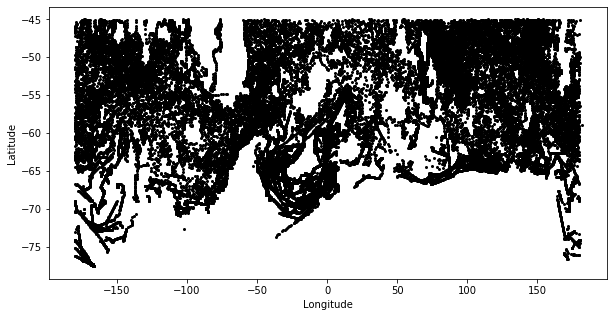

In [53]:
plt.figure(figsize=(10,5))
plt.scatter(SO_profile_meta_data['lons'], SO_profile_meta_data['lats'], s=4, c='k')
plt.ylabel("Latitude")
plt.xlabel("Longitude")

Color by year and month

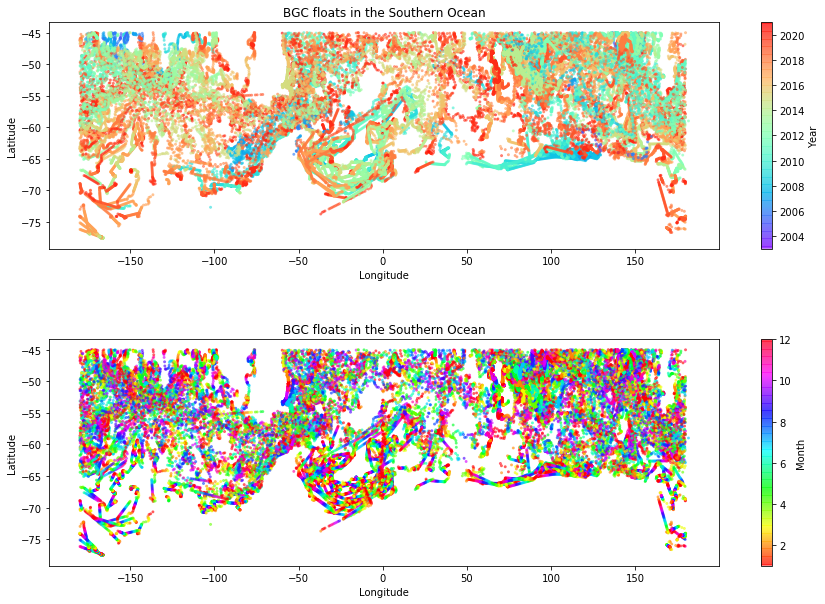

In [63]:
#years = np.array([dt.year for dt in SO_profile_meta_data['time']])
years = np.nan*np.zeros(len(SO_profile_meta_data['time']))
months = np.nan*np.zeros(len(SO_profile_meta_data['time']))
for i, dt in enumerate(SO_profile_meta_data['time']):
    try:
        years[i] = dt.year
        months[i] = dt.month
    except:
        continue


plt.figure(figsize=(15,10))
plt.subplot(211)
plt.scatter(SO_profile_meta_data['lons'], SO_profile_meta_data['lats'], c=years, s=4, alpha=0.5,
            cmap=plt.cm.rainbow)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("BGC floats in the Southern Ocean")
plt.colorbar(label='Year')

plt.subplot(212)
plt.scatter(SO_profile_meta_data['lons'], SO_profile_meta_data['lats'], c=months, s=4, alpha=0.5,
            cmap=plt.cm.hsv)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("BGC floats in the Southern Ocean")
plt.colorbar(label='Month')

plt.subplots_adjust(hspace=0.4)


These plots are kinda ugly. It's probably better to plot each month or year separately. Moving on...

## Plot  random profile

In [67]:
idx = 12343 # random number

# print profile info
for key in SO_profile_meta_data:
    print(SO_profile_meta_data[key][idx])

aoml_bgc/5904165/profiles/BD5904165_079.nc
-76.434
-172.096
2015-06-15 21:40:56
['PRES', 'DOXY', 'TEMP_DOXY', 'TPHASE_DOXY', 'RPHASE_DOXY']


In [69]:
#load data
profile_fpath = os.path.join(argo_data_dir, SO_profile_meta_data['filepaths'][idx])

# use xarray to load netcdf data
ds_test = xr.open_dataset(profile_fpath)

print(ds_test)

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_HISTORY: 3, N_LEVELS: 229, N_PARAM: 5, N_PROF: 2)
Dimensions without coordinates: N_CALIB, N_HISTORY, N_LEVELS, N_PARAM, N_PROF
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object ...
    PROJECT_NAME                  (N_PROF) object ...
    PI_NAME                       (N_PROF) object ...
    STATION_PARAMETERS            (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                  (N_PROF) float64 ...
    DIRECTION                     (N_PROF) object ...
    DATA_CENTRE                   (N_PROF) object ...
    DC_REFERENCE                  (N_PROF) object ...
    DATA_STATE_INDICATOR          (N_PROF) object ...
    DATA_MODE           

It's not clear to me why there are two profiles in this dataset. Let's plot the doxy profile

In [70]:
print(ds_test['DOXY'])

<xarray.DataArray 'DOXY' (N_PROF: 2, N_LEVELS: 229)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [235.6925, 235.7924, 235.8047, ...,      nan,      nan,      nan]],
      dtype=float32)
Dimensions without coordinates: N_PROF, N_LEVELS
Attributes:
    long_name:       Dissolved oxygen
    standard_name:   moles_of_oxygen_per_unit_mass_in_sea_water
    units:           micromole/kg
    valid_min:       -5.0
    valid_max:       600.0
    C_format:        %7.1f
    FORTRAN_format:  F7.1
    resolution:      0.1


(500, 0)

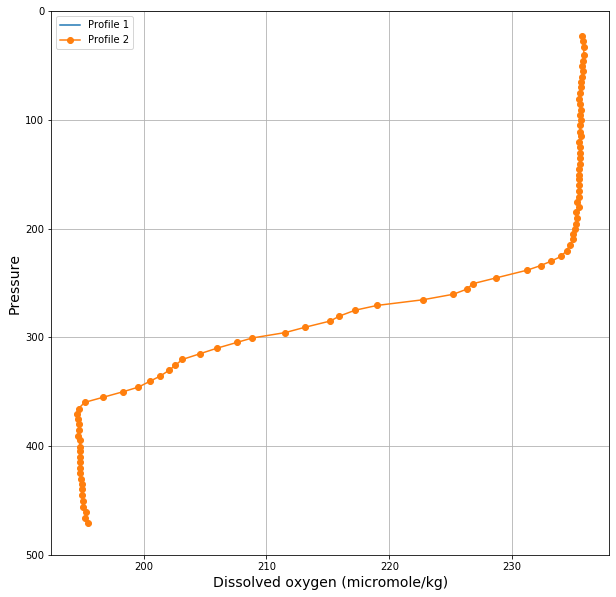

In [79]:
fz = 14
plt.figure(figsize=(10, 10))
plt.plot(ds_test['DOXY'][0, :], ds_test['PRES'][0, :], '-', label='Profile 1')
plt.plot(ds_test['DOXY'][1, :], ds_test['PRES'][1, :], '-o', label='Profile 2')
plt.legend()
plt.grid(True)
plt.ylabel("Pressure", fontsize=fz)
plt.xlabel("%s (%s)" %(ds_test['DOXY'].long_name, ds_test['DOXY'].units), fontsize=fz)
plt.ylim(500, 0) # flip axis

Cool. First profile seems to be filled with nans.

In [77]:
ds_test['DOXY'][0, :]

<xarray.DataArray 'DOXY' (N_LEVELS: 229)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Dimensions without coordinates: N_LEVELS
Attributes:
    long_name:       Dissolved oxygen
    standard_name:   moles_of_oxygen_per_unit_mass_in_sea_water
    units:           micromole/kg
    valid_min:       -5.0
    valid_max:       600.0
    C_format:        %7.1f
    FORTRAN_format:  F7.1
    resolution:      0.1